In [1]:
import os
os.chdir('/home/renwh/gaze/renwh/caffe_with_cudnnv3/')

import sys
sys.path.insert(0,'./python')
import caffe

from pylab import *
%matplotlib inline


caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/mymodel/00/lenet_solver.prototxt')

#You can choose to load your model status
#solver.restore('examples/mymodel/03/lenet_iter_1001.solverstate')

In [2]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1000, 1, 36, 60)),
 ('label', (1000, 6)),
 ('gaze', (1000, 3)),
 ('headpose', (1000, 3)),
 ('conv1', (1000, 20, 32, 56)),
 ('pool1', (1000, 20, 16, 28)),
 ('conv2', (1000, 50, 12, 24)),
 ('pool2', (1000, 50, 6, 12)),
 ('ip1', (1000, 500)),
 ('cat', (1000, 503)),
 ('ip2', (1000, 3)),
 ('loss', ())]

In [3]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('ip1', (500, 3600)),
 ('ip2', (3, 503))]

In [7]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(0.5358729362487793, dtype=float32)}

[[-0.19040217  0.04475503 -0.98068547 -0.11398691  0.36006123  0.02076935]
 [-0.02839583 -0.00487343 -0.99958485 -0.13608566 -0.08653714 -0.00590104]
 [-0.26294383  0.00812946 -0.96477687 -0.25317603  0.11678624  0.01488054]
 [-0.04674562  0.02810747 -0.99851131 -0.41980183 -0.05958758 -0.01269848]
 [ 0.03442577  0.06966881 -0.99697602 -0.78683364 -0.06924258 -0.02875397]
 [-0.22842847  0.17450288 -0.95779389 -0.10679594  0.16373932  0.00877136]
 [-0.09690065  0.10598393 -0.98963511 -0.26147738 -0.09330522 -0.01227772]
 [ 0.10869349  0.15902732 -0.98127264 -0.07023501 -0.10542145 -0.0037071 ]]


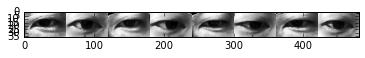

In [8]:
# we use a little trick to tile the first eight images
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(36, 8*60), cmap='gray')
print solver.net.blobs['label'].data[:8]

In [9]:
solver.step(1)

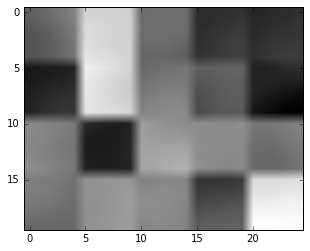

In [10]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

Show the conv1 weights pics.


Then, I will train the model, and log some information.

In [11]:
%%time
niter = 1000
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
mean_error= zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 3))


# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        # caculate the square error for each gaze vector
        solver.test_nets[0].forward()
        
        num_test = 100;
        sub_error = zeros((num_test, 3))
        square_error = zeros((num_test, 3))
        sum_square_error = zeros(num_test)
        for i in range(num_test):
            sub_error[i,:] = np.subtract(solver.test_nets[0].blobs['label'].data[i,:3]
                                         , solver.test_nets[0].blobs['ip2'].data[i])
            square_error = np.square(sub_error)
            sum_square_error = np.sum(square_error,1)
        mean_error[it // test_interval] = np.sum(sum_square_error,0)/num_test*180
        print 'Iteration', it, '. Mean error is', mean_error[it // test_interval]
    

Iteration 0 . Mean error is 37.4751093978
Iteration 25 . Mean error is 6.62781938912
Iteration 50 . Mean error is 3.20453071848
Iteration 75 . Mean error is 4.00814398266
Iteration 100 . Mean error is 4.54671262992
Iteration 125 . Mean error is 4.39850831843
Iteration 150 . Mean error is 4.90806511241
Iteration 175 . Mean error is 3.62737378584
Iteration 200 . Mean error is 6.88032497144
Iteration 225 . Mean error is 5.90642332355
Iteration 250 . Mean error is 3.32993514835
Iteration 275 . Mean error is 6.09943767279
Iteration 300 . Mean error is 3.10590062999
Iteration 325 . Mean error is 4.00919011289
Iteration 350 . Mean error is 5.87651993163
Iteration 375 . Mean error is 2.83347810031
Iteration 400 . Mean error is 4.53114897047
Iteration 425 . Mean error is 4.17904391314
Iteration 450 . Mean error is 4.02971741735
Iteration 475 . Mean error is 4.61001098452
Iteration 500 . Mean error is 5.56539470446
Iteration 525 . Mean error is 3.06680004506
Iteration 550 . Mean error is 3.67206

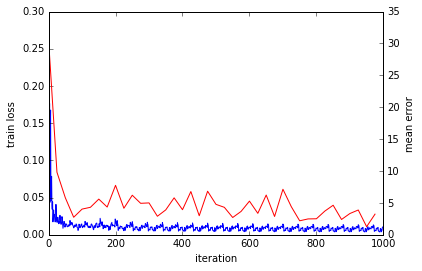

In [9]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(mean_error)), mean_error, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('mean error')

**show you the train loss curve.

--------------------------------------------------------------------------------------------------------------
1000 test pic, mean error is  3.88262057074 degree


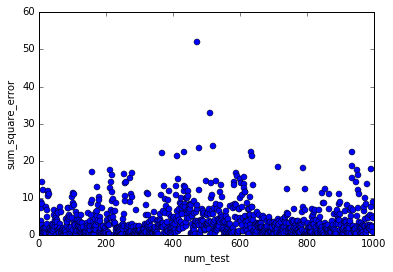

In [17]:
num_test = 1000
#figure(figsize=(10, 5))
#imshow(solver.test_nets[0].blobs['data'].data[:num_test, 0].transpose(1, 0, 2).reshape(36, num_test*60), cmap='gray')
    
# print the label and train result
#for i in range(num_test):
#    print solver.test_nets[0].blobs['label'].data[i,:3] ,'label<->ip2', solver.test_nets[0].blobs['ip2'].data[i]

# (start the forward pass at conv1 to avoid loading new data)
solver.test_nets[0].forward(start='conv1')
solver.test_nets[0].forward()

print '--------------------------------------------------------------------------------------------------------------'
# caculate the square error for each gaze vector
sub_error = zeros((num_test, 3))
square_error = zeros((num_test, 3))
sum_square_error = zeros(num_test)
for i in range(num_test):
    sub_error[i,:] = np.subtract(solver.test_nets[0].blobs['label'].data[i,:3], solver.test_nets[0].blobs['ip2'].data[i])
    square_error = np.square(sub_error)
    sum_square_error = np.sum(square_error,1)
    #print sub_error[i,:],square_error[i,:],sum_square_error[i]
    #print sum_square_error[i],
print num_test,'test pic, mean error is ',np.sum(sum_square_error,0)/num_test*180,'degree'
_, ax1 = subplots()
ax1.plot(arange(num_test), sum_square_error*180,'bo', label='sampled')
ax1.set_xlabel('num_test')
ax1.set_ylabel('sum_square_error')

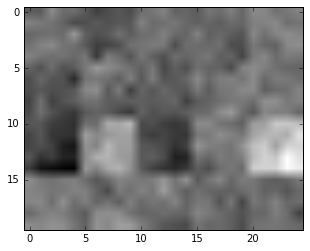

In [18]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

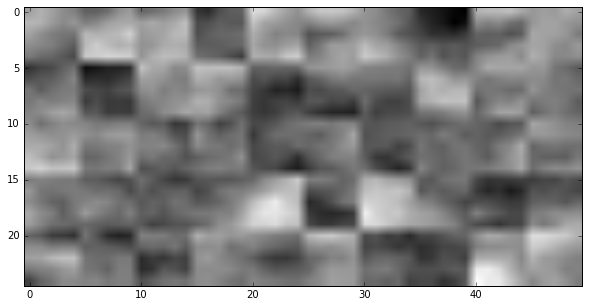

In [19]:
figure(figsize=(10, 5))
imshow(solver.net.params['conv2'][0].diff[:, 0].reshape(5, 10, 5, 5)
       .transpose(0, 2, 1, 3).reshape(5*5, 10*5), cmap='gray')

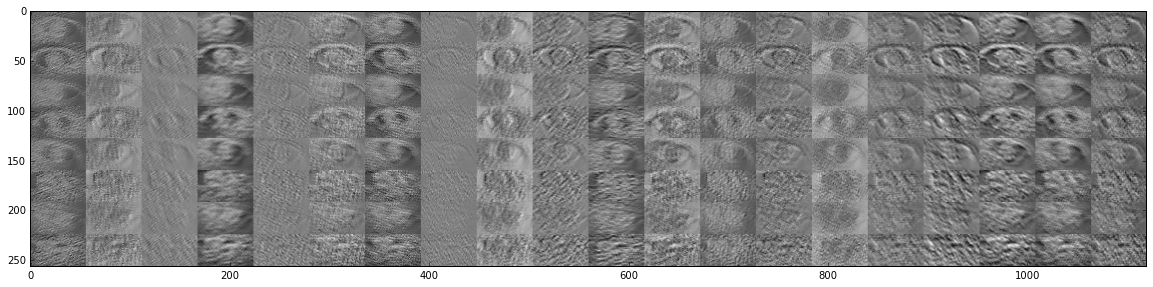

In [20]:
figure(figsize=(20, 10))
imshow(solver.test_nets[0].blobs['conv1'].data[:8, :].reshape(8,20,32,56)
           .transpose(0,2,1,3).reshape(8*32, 20*56), cmap='gray')

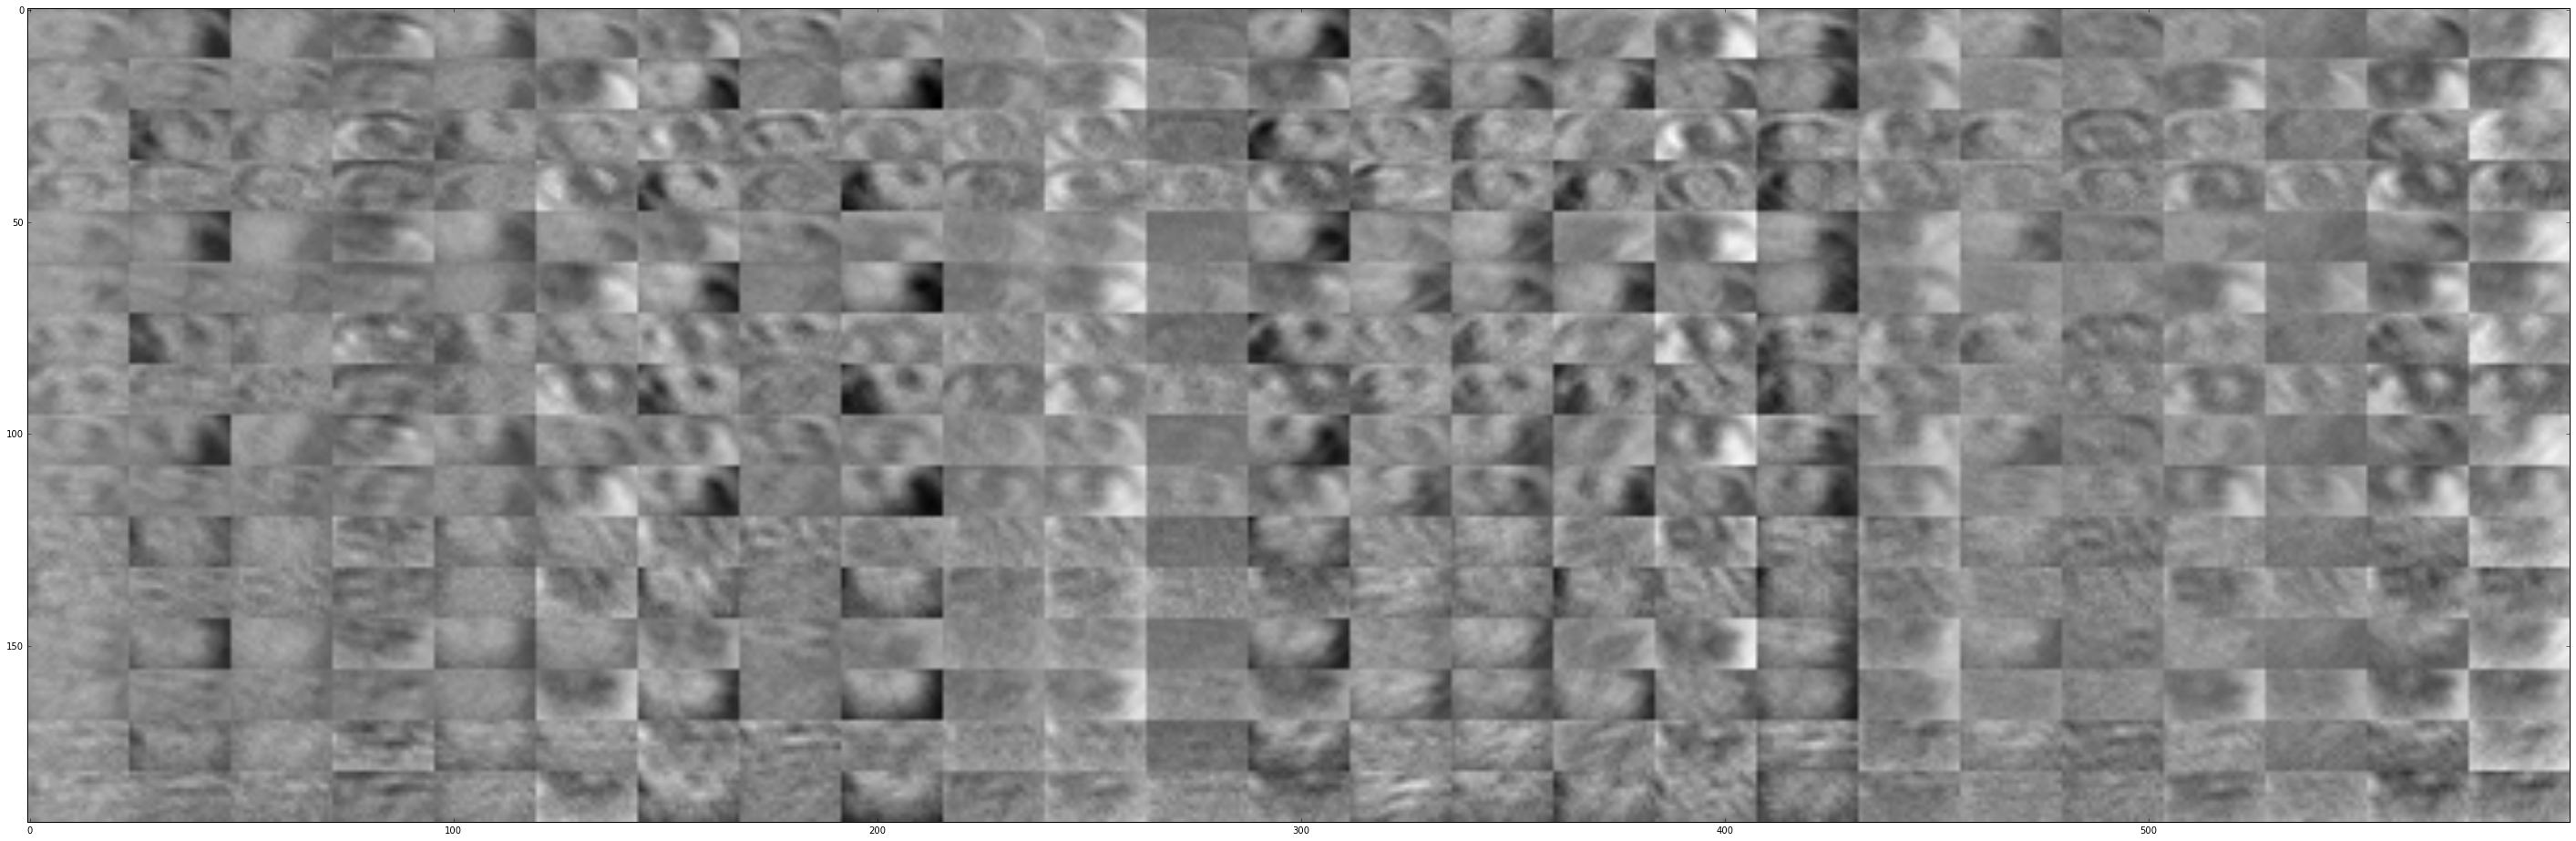

In [21]:
figure(figsize=(50, 25))
imshow(solver.test_nets[0].blobs['conv2'].data[:8, :].reshape(16, 25, 12, 24)
       .transpose(0,2,1,3).reshape(16*12, 25*24), cmap='gray')

In [ ]:
#solver.net.save('my_model.caffemodel') I do not know how to use this.
solver.snapshot() #SAVE MY MODEL IN THE DIR YOU DEFINE IN SOLVER FILE.